In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [4]:
df = pd.read_csv('data/train-data.csv')
df.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


In [6]:
df.drop(columns = ['Unnamed: 0','New_Price'],inplace = True)

In [7]:
df.duplicated().sum()

0

In [8]:
df['Mileage'] = df['Mileage'].str.split(expand=True)[0].astype(float)

In [9]:
df['Engine'] = df['Engine'].str.split(expand=True)[0].astype(float)

In [10]:
(df['Power'] == 'null bhp').sum()

107

In [11]:
df['Power'] = df['Power'].replace('null bhp',None)
df['Power'] = df['Power'].str.split(expand=True)[0].astype(float)

In [12]:
df.sample()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
3379,Renault Duster 85PS Diesel RxL Optional with Nav,Jaipur,2012,97000,Diesel,Manual,Second,20.45,1461.0,83.8,5.0,4.25


In [13]:
df.describe()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price
count,6019.000000,6.019000e+03,6017.000000,5983.000000,5876.000000,5977.000000,6019.000000
mean,2013.358199,5.873838e+04,18.134961,1621.276450,113.253050,5.278735,9.479468
std,3.269742,9.126884e+04,4.582289,601.355233,53.874957,0.808840,11.187917
min,1998.000000,1.710000e+02,0.000000,72.000000,34.200000,0.000000,0.440000
25%,2011.000000,3.400000e+04,15.170000,1198.000000,75.000000,5.000000,3.500000
50%,2014.000000,5.300000e+04,18.150000,1493.000000,97.700000,5.000000,5.640000
75%,2016.000000,7.300000e+04,21.100000,1984.000000,138.100000,5.000000,9.950000
max,2019.000000,6.500000e+06,33.540000,5998.000000,560.000000,10.000000,160.000000


In [14]:
df.select_dtypes('object').describe()

,Name,Location,Fuel_Type,Transmission,Owner_Type
count,6019,6019,6019,6019,6019
unique,1876,11,5,2,4
top,Mahindra XUV500 W8 2WD,Mumbai,Diesel,Manual,First
freq,49,790,3205,4299,4929


In [15]:
for col in ['Engine','Power','Kilometers_Driven','Mileage','Price']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2.5*IQR
    upper_bound = Q3 + 2.5*IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [16]:
df['Name'].nunique()

1633

In [17]:
df['Company'] = df['Name'].str.split(expand=True)[0].str.lower()
df['Model'] = df['Name'].str.split().str[0:2].str.join(' ').str.lower()
df.drop(columns = ['Name'],inplace = True)

In [18]:
df['Company'].nunique() , df['Model'].nunique()

(26, 182)

In [19]:
def remove_outliers(df,col,lower,upper):
    df = df[ (df[col]>lower) & (df[col]<upper) ]
    return df

In [20]:
def plot_num(df,col):
    fig ,ax = plt.subplots(1,2,figsize=(16,4))
    sns.histplot(df,x=col,kde=True,ax=ax[0])
    sns.boxplot(df,x=col,ax=ax[1])
    ax[0].set_title(f'Distribution of {col}')
    ax[1].set_title(f'{col} Boxplot')
    fig.show();

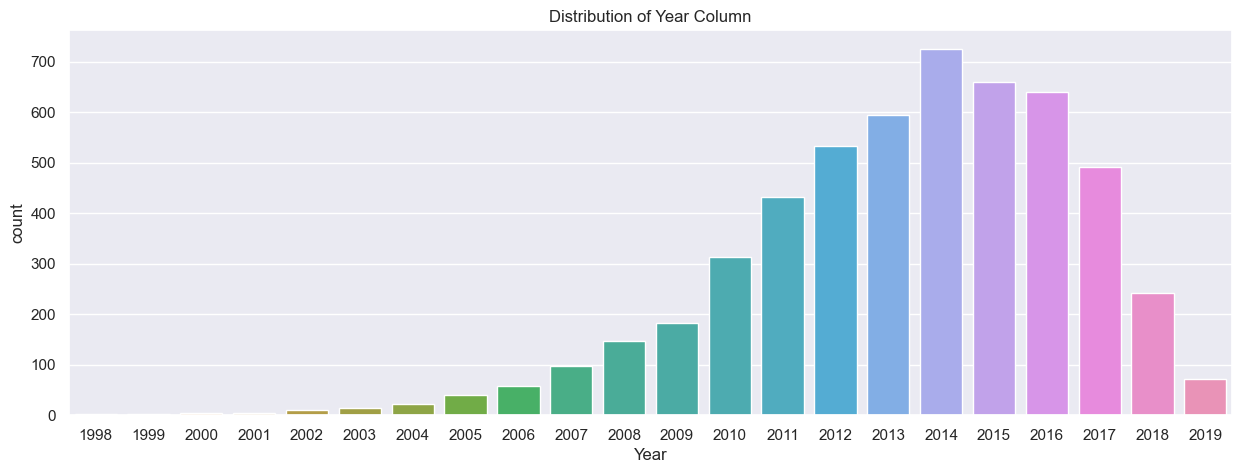

In [21]:
plt.figure(figsize=(15,5))
sns.countplot(df,x='Year');
plt.title('Distribution of Year Column');